In [39]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from numpy.random import poisson
import ast, pickle

from Class_utils.parameters import *
from Class_utils.FitnessClasses import FitnessAge,FitnessExperience, FitnessCity
from Generator.MatchingScore import MatchingScore

from sklearn.cluster import KMeans

%reload_ext autoreload
%autoreload 2

# Distributions

In [40]:
df_language_level = pd.read_csv(file_paths["languages_level_path"],index_col=0) # dataframe with language levels

poisson_dist = [poisson(lam=2) for _ in range(60000)]
poisson_x = [i for i in range(max(poisson_dist))]

df_education_level = pd.read_csv(file_paths["education_path"]) # dataframe with language levels
education_level_dist =  df_education_level["Distribution"].tolist()
name_edu_levels = df_education_level["Education"]

dt_language = pd.read_csv(file_paths["languages_path"],index_col=0)
languages,prob = dt_language.index.to_numpy(), dt_language.Prob.to_numpy()
sorted_order = np.argsort(prob,kind="stable")
languages,prob = languages[sorted_order], prob[sorted_order]

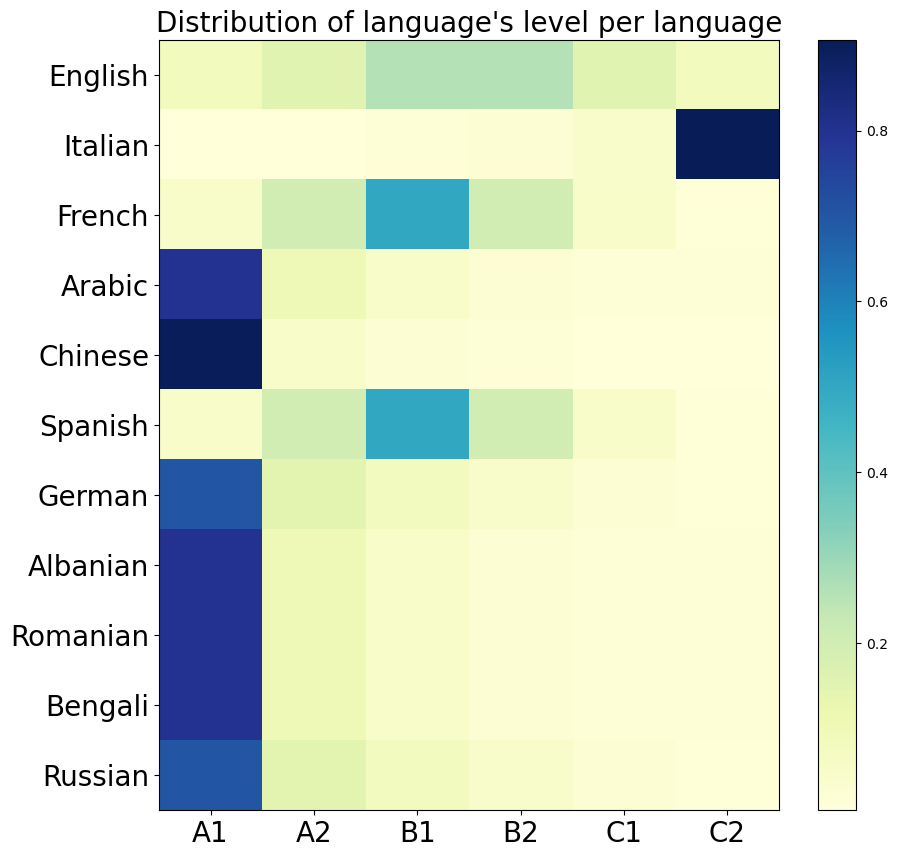

In [41]:
_, axs = plt.subplots(ncols=1,nrows=1,figsize=(10,10))
img = axs.imshow(df_language_level.values, cmap='YlGnBu', interpolation='nearest', aspect='auto')
axs.set_title('Distribution of language\'s level per language',  fontsize=20)
axs.set_xticks(range(df_language_level.shape[1]), list(df_language_level.columns))
axs.set_yticks(range(df_language_level.shape[0]), list(df_language_level.index))
axs.tick_params(axis='both', which='major', labelsize=20)
axs.tick_params(axis='both', which='minor', labelsize=20)
plt.colorbar(img, ax=axs)
plt.show()

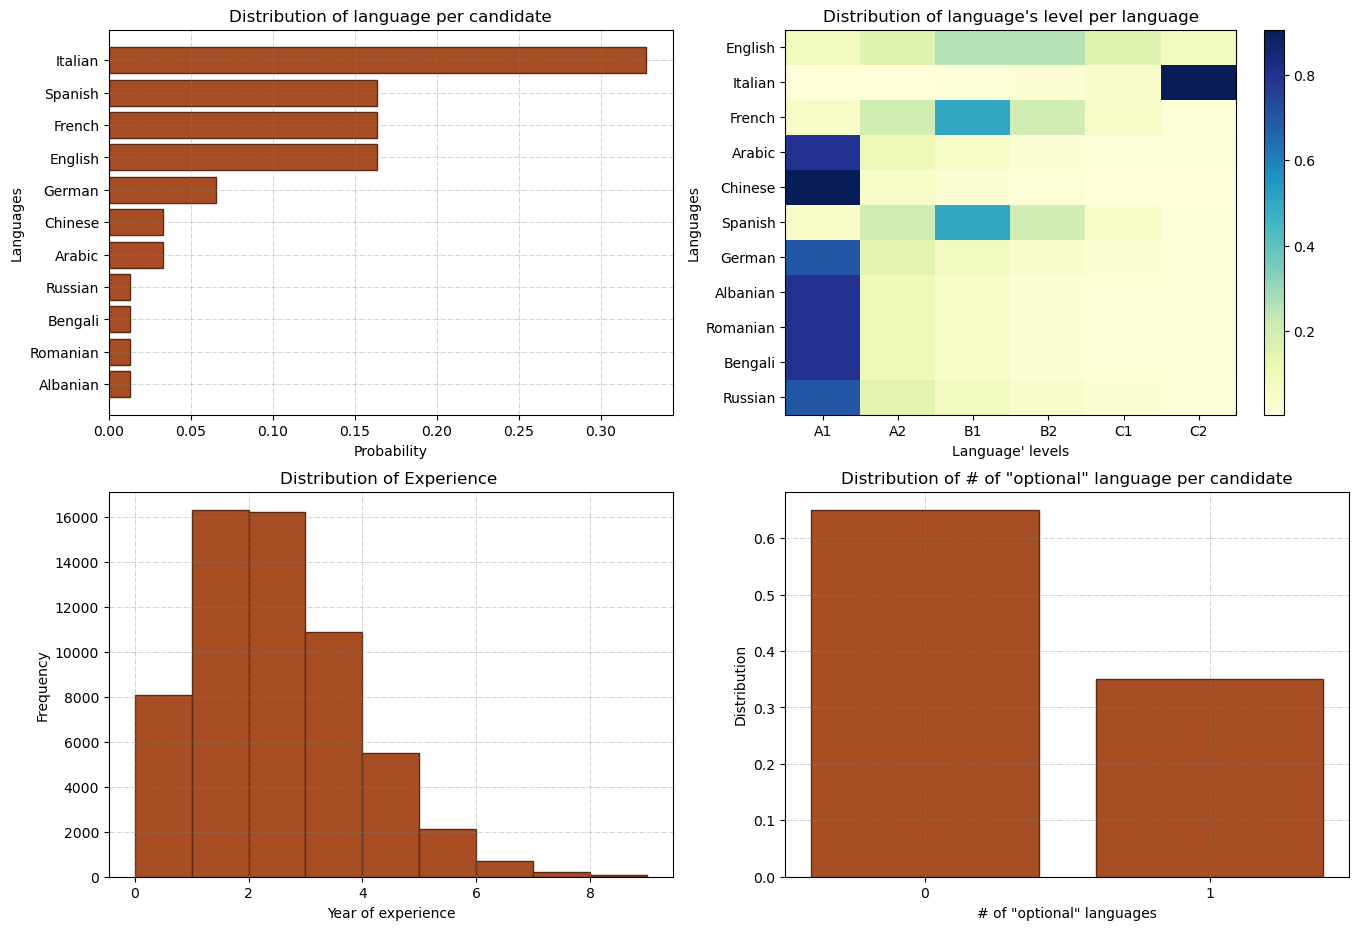

In [42]:
default_par = dict(
    color="#a74e25",
    edgecolor="#5b2a14"
)

f, axs = plt.subplots(ncols=2,nrows=2,figsize=(16,11))

axs[0,0].barh(range(len(languages)), prob/prob.sum(), **default_par)
axs[0,0].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[0,0].set_yticks(range(len(languages)), languages)
axs[0,0].set_title('Distribution of language per candidate')
axs[0,0].set_xlabel('Probability')
axs[0,0].set_ylabel('Languages')

img = axs[0,1].imshow(df_language_level.values, cmap='YlGnBu', interpolation='nearest', aspect='auto')
axs[0,1].set_title('Distribution of language\'s level per language')
axs[0,1].set_xticks(range(df_language_level.   shape[1]), list(df_language_level.columns))
axs[0,1].set_yticks(range(df_language_level.shape[0]), list(df_language_level.index))
axs[0,1].set_xlabel('Language\' levels')
axs[0,1].set_ylabel('Languages')

axs[1,0].hist(poisson_dist, poisson_x, **default_par)
axs[1,0].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[1,0].set_title('Distribution of Experience ')
axs[1,0].set_xlabel('Year of experience')
axs[1,0].set_ylabel('Frequency')

axs[1,1].bar(range(len(file_paths["opt_lang_distribution"])), file_paths["opt_lang_distribution"], **default_par)
axs[1,1].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[1,1].set_xticks(range(len(file_paths["opt_lang_distribution"])), range(len(file_paths["opt_lang_distribution"])))
axs[1,1].set_title('Distribution of # of "optional" language per candidate')
axs[1,1].set_xlabel('# of "optional" languages')
axs[1,1].set_ylabel('Distribution')

plt.colorbar(img, ax=axs[0,1])
plt.show()

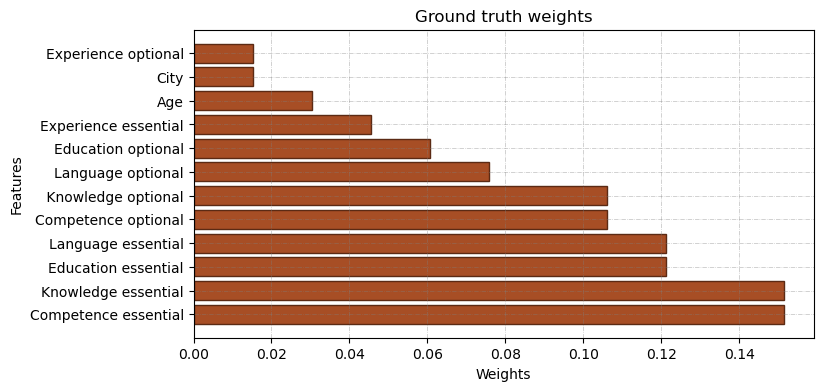

In [43]:
n_weights = MatchingScore.normalize_weights(matching_par["weight"])

sort_ = np.argsort(-n_weights)

features = np.array(["Education essential","Education optional","City","Age","Experience essential","Experience optional","Language essential","Language optional", "Competence essential","Competence optional","Knowledge essential"," Knowledge optional"])

_, axs = plt.subplots(figsize=(8,4))
axs.barh(range(len(n_weights)), n_weights[sort_], **default_par)
axs.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs.set_yticks(range(len(n_weights)), features[sort_])
axs.set_title("Ground truth weights")
axs.set_xlabel('Weights')
axs.set_ylabel('Features')
plt.show()

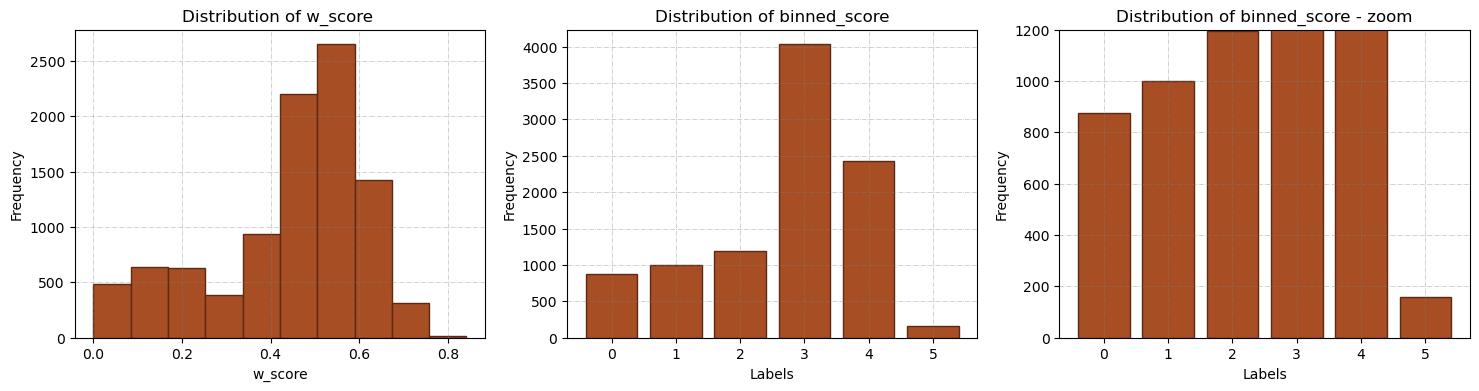

In [44]:
score_dt = pd.read_csv("../outputs/scores/0_dataset.csv")
binned_score = score_dt["binned_score"].tolist()
w_score = score_dt["w_score"].tolist()

distri_labels = [binned_score.count(i) for i in range(max(binned_score)+1)]
name_label = [*range(max(binned_score)+1)]

_, axs = plt.subplots(ncols=3,figsize=(18,4))

axs[0].hist(w_score, **default_par)
axs[0].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[0].set_title('Distribution of w_score ')
axs[0].set_xlabel('w_score')
axs[0].set_ylabel('Frequency')

axs[1].bar(name_label,distri_labels, **default_par)
axs[1].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[1].set_title('Distribution of binned_score')
axs[1].set_xlabel('Labels')
axs[1].set_ylabel('Frequency')

axs[2].bar(name_label,distri_labels, **default_par)
axs[2].set_ylim(0, 1200)
axs[2].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[2].set_title('Distribution of binned_score - zoom')
axs[2].set_xlabel('Labels')
axs[2].set_ylabel('Frequency')


plt.show()

# Fitness functions

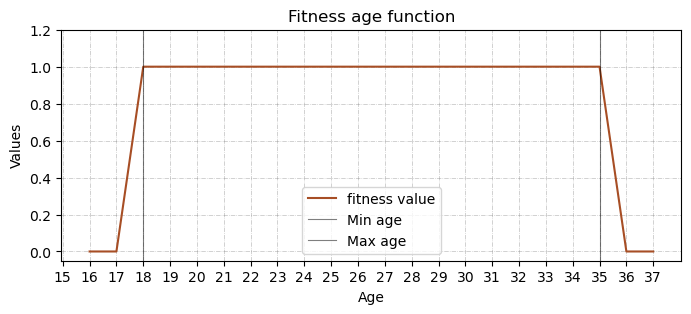

In [45]:
min_age, max_age = 18, 35
ages = [*range(16,37+1)]
age_score = [FitnessAge.fitness_basic(i,min_age,max_age) for i in ages]

_, axs = plt.subplots(figsize=(8,3))

axs.plot(ages,age_score, color=default_par["color"],label="fitness value")
axs.axvline(min_age, alpha=0.5,linewidth=0.8, color="black", label="Min age")
axs.axvline(max_age, alpha=0.5,linewidth=0.8, color="black", label="Max age")
axs.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs.set_ylim(-0.05,1.2)
axs.set_xticks(np.arange(15, 37 + 1, 1))
axs.set_title("Fitness age function")
axs.set_xlabel('Age')
axs.set_ylabel('Values')
axs.legend()
plt.show()

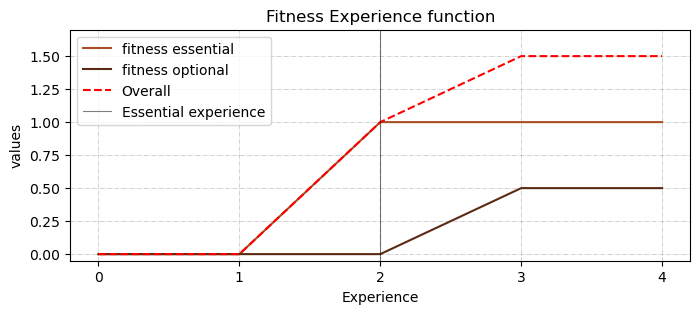

In [46]:
exp_essential,exp_optional = 2, True
experience = [*range(0,5)]

basic_score, bonus_score = [], []
for i in experience:
    a = FitnessExperience.fitness_basic(exp_essential,i)
    b = FitnessExperience.fitness_bonus(exp_essential, exp_optional, i)
    basic_score.append(a)
    bonus_score.append(b)

overall = [a + b for a,b in zip(basic_score,bonus_score)]
_, axs = plt.subplots(figsize=(8,3))

axs.plot(experience, basic_score, color=default_par["color"], label="fitness essential")
axs.plot(experience, bonus_score, color=default_par["edgecolor"], label="fitness optional")
axs.plot(experience, overall, color="red", linestyle="--", label="Overall")
axs.axvline(exp_essential, alpha=0.5,linewidth=0.8, color="black", label="Essential experience")
axs.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs.set_ylim(-0.05,1.7)
axs.set_xticks(np.arange(0,5,1))
axs.set_title("Fitness Experience function")
axs.set_xlabel('Experience')
axs.set_ylabel('values')
axs.legend()
plt.show()

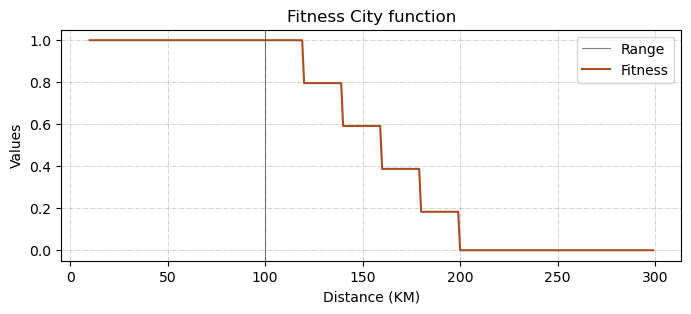

In [47]:
fitness_city = FitnessCity("../sources/cities_distance.csv")

range_ = 100
distances = [*range(10,300,1)]
fitness = [fitness_city.distance_scoring(d, range_) for d in distances]

_, axs = plt.subplots(figsize=(8,3))

axs.axvline(range_, alpha=0.5,linewidth=0.8, color="black", label="Range")
axs.plot(distances,fitness, label="Fitness", color=default_par["color"])
axs.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs.set_title("Fitness City function")
axs.set_xlabel('Distance (KM)')
axs.set_ylabel('Values')
axs.set_ylim(-0.05,1.05)

axs.legend()
plt.show()

# Consistent curricula

In [48]:
curricula = pd.read_csv("../outputs/0_curricula.csv",usecols=[1,2])
vl_set = pd.read_csv("../outputs/scores/0_dataset_vl.csv").set_index("kId")

In [49]:
with open("../Models/GlassBox/figs/saved_models/FIGSReg.pkl", 'rb') as file:
    model_figs = pickle.load(file)
with open("../Models/GlassBox/ebm/saved_models/EBMReg.pkl", 'rb') as file:
    model_ebm = pickle.load(file)
with open("../Models/BlackBox/lmart/saved_models/LGBMRanker.pkl", 'rb') as file:
    model_lgbm = pickle.load(file)

In [50]:
df_normalized  = pd.json_normalize(curricula['metadata'].apply(ast.literal_eval))
curricula = pd.concat([curricula, df_normalized], axis=1)[["kId","consistent"]].set_index("kId")


curricula = vl_set.merge(curricula, on="kId")[["w_score","consistent"]]
curricula['consistent'] = curricula['consistent'].apply(lambda x: 1 if x else 0 )

lambda_figs = model_figs.predict(vl_set.iloc[:,4:].to_numpy())
lambda_ebm = model_ebm.predict(vl_set.iloc[:,4:].to_numpy())
lambda_lgbm = model_lgbm.predict(vl_set.iloc[:,4:].to_numpy())
vl_set["lambda_figs"] = lambda_figs
vl_set["lambda_ebm"] = lambda_ebm
vl_set["lambda_lgbm"] = lambda_lgbm

curricula = vl_set[["lambda_figs","lambda_ebm","lambda_lgbm"]].merge(curricula, on="kId")

label = ""

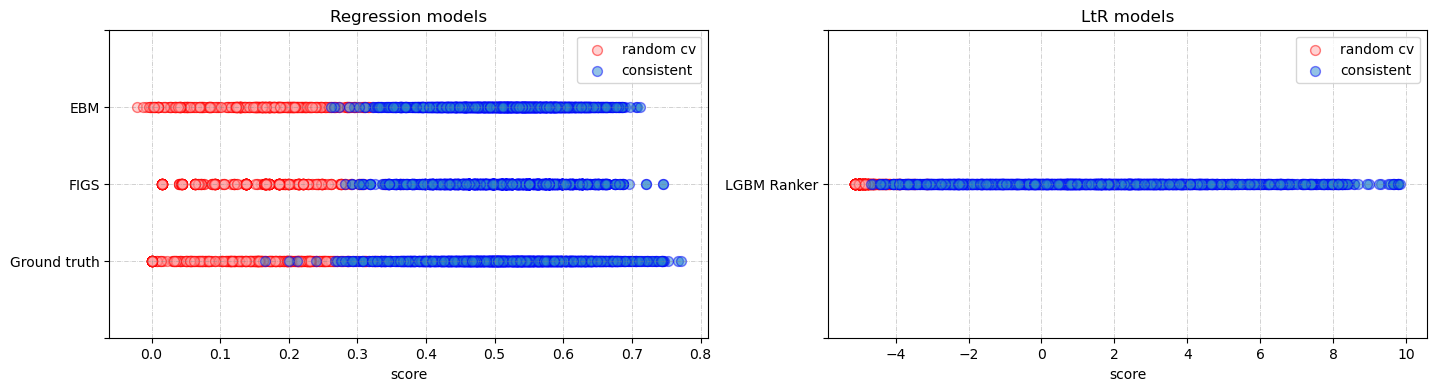

In [51]:
fig, axs = plt.subplots(1,2, figsize=(17,4))

constant = np.ones((len(curricula)))
params = dict(s=50, alpha=0.5)
params_a = dict(c="#FFA6A7",edgecolor="red")
params_b = dict(c="#2986CC",edgecolor="Blue")

for idx, v in enumerate(["w_score","lambda_figs","lambda_ebm"],1):
    t1 = curricula[curricula["consistent"]==0][v]
    t2 = curricula[curricula["consistent"]==1][v]
    label_a,label_b = "random cv" if idx == 1 else "", "consistent" if idx == 1 else ""
    axs[0].scatter(t1,np.ones_like(t1)*idx, **params, **params_a, label=label_a)
    axs[0].scatter(t2,np.ones_like(t2)*idx, **params, **params_b, label=label_b)

axs[0].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[0].set_yticks(np.arange(0,5,1), ["","Ground truth","FIGS","EBM",""])
axs[0].set_xlabel("score")
axs[0].set_title("Regression models")
axs[0].legend()

for idx, v in enumerate(["lambda_lgbm"],1):
    t1 = curricula[curricula["consistent"]==0][v]
    t2 = curricula[curricula["consistent"]==1][v]
    label_a,label_b = "random cv" if idx == 1 else "", "consistent" if idx == 1 else ""
    axs[1].scatter(t1,np.ones_like(t1)*idx, **params, **params_a, label=label_a)
    axs[1].scatter(t2,np.ones_like(t2)*idx, **params, **params_b, label=label_b)

axs[1].grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
axs[1].set_yticks(np.arange(0,3,1), ["","LGBM Ranker",""])
axs[1].set_xlabel("score")
axs[1].set_title("LtR models")
axs[1].legend()

plt.show()

# Advanced Binning

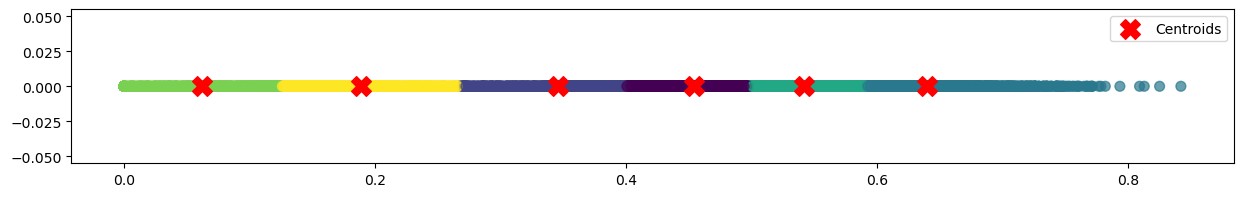

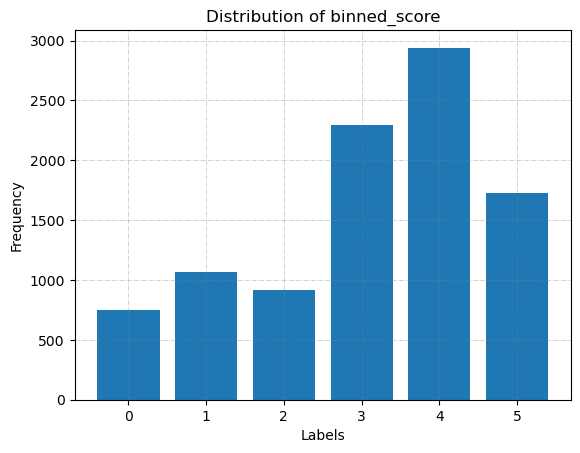

In [52]:
w_score = pd.read_csv("../outputs/scores/0_dataset.csv",usecols=[3]).to_numpy()

n_cluster = 6
kmeans = KMeans(n_clusters=n_cluster, random_state=42, n_init="auto")
kmeans.fit(w_score)


clusters = pd.DataFrame(kmeans.cluster_centers_,columns=["clus_pos"])
clusters["rank"] =clusters.clus_pos.rank().astype(int)-1
map_dict = clusters["rank"].to_dict()
labeled = list(map(lambda x: map_dict[x], kmeans.labels_))
distri_labels = [labeled.count(i) for i in range(max(labeled)+1)]
name_label = [*range(max(labeled)+1)]


plt.figure(figsize=(15,2))
plt.scatter(w_score, np.zeros_like(w_score), c=kmeans.labels_, cmap='viridis', s=50, alpha=0.7)
plt.scatter(kmeans.cluster_centers_, np.zeros_like(kmeans.cluster_centers_), c='red', marker='X', s=200, label='Centroids')
plt.legend()
plt.show()

plt.bar(name_label, distri_labels)
plt.grid(color='grey', linestyle='-.', linewidth=0.5, alpha=0.5)
plt.title('Distribution of binned_score')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()